In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-muted")

df = pd.read_csv("health_armaan.csv", parse_dates=["date"]).sort_values("date").reset_index(drop=True)


In [34]:
target = "RestingHeartRate"
df = df[df["date"] >= "2022-12-01"].reset_index(drop=True)
candidate_features = [
    # Activity & Energy
    "StepCount","DistanceWalkingRunning","DistanceCycling",
    "AppleExerciseTime","AppleStandTime","FlightsClimbed",
    "ActiveEnergyBurned","BasalEnergyBurned","EnergyBalance",
    # Mobility & Stability
    "WalkingSpeed","WalkingStepLength",
    "WalkingAsymmetryPercentage","WalkingDoubleSupportPercentage",
    "MobilityIndex","StabilityIndex",
    # Cardio context
    "HeartRateVariabilitySDNN","WalkingHeartRateAverage","HRFitnessIndex",
    # Lifestyle
    "TimeInDaylight","HeadphoneAudioExposure",
    # Calendar (can help a model capture seasonality)
    "year","month","week"
]

features = [c for c in candidate_features if c in df.columns]
print("Using", len(features), "features")

X = df[features].copy()
X = X.fillna(X.median(numeric_only=True))
y = df[target].copy()

mask = y.notna()
X, y, dates = X.loc[mask].reset_index(drop=True), y.loc[mask].reset_index(drop=True), df.loc[mask, "date"].reset_index(drop=True)

X.head(3)


Using 23 features


,StepCount,DistanceWalkingRunning,DistanceCycling,AppleExerciseTime,AppleStandTime,FlightsClimbed,ActiveEnergyBurned,BasalEnergyBurned,EnergyBalance,WalkingSpeed,...,MobilityIndex,StabilityIndex,HeartRateVariabilitySDNN,WalkingHeartRateAverage,HRFitnessIndex,TimeInDaylight,HeadphoneAudioExposure,year,month,week
0,14504.0,12.193553,0.0,31.562998,200.0,30.0,426.291455,2057.051,0.279216,4.396836,...,38.332746,0.156603,51.2814,87.0,0.813990,56.0,1326.48660,2022,12,48
1,17485.0,14.499583,0.0,29.902013,315.0,45.0,478.148945,2198.746,0.349877,4.293649,...,38.306619,0.154171,51.9349,107.0,0.865582,56.0,8818.86011,2022,12,48
2,13855.0,11.249942,0.0,17.472564,331.0,31.0,396.467355,2190.468,0.327446,4.093826,...,37.128435,0.173071,62.2190,92.0,1.072741,56.0,5146.76780,2022,12,48


In [35]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

linr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

rfr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

pred_lin = np.zeros(len(y))
pred_rf  = np.zeros(len(y))

for tr, te in tscv.split(X):
    # Linear
    linr.fit(X.iloc[tr], y.iloc[tr])
    pred_lin[te] = linr.predict(X.iloc[te])
    # RF
    rfr.fit(X.iloc[tr], y.iloc[tr])
    pred_rf[te] = rfr.predict(X.iloc[te])

mae_lin = mean_absolute_error(y, pred_lin)
r2_lin  = r2_score(y, pred_lin)
mae_rf  = mean_absolute_error(y, pred_rf)
r2_rf   = r2_score(y, pred_rf)

print(f"Linear Regression  →  MAE: {mae_lin:.2f} | R²: {r2_lin:.3f}")
print(f"Random Forest      →  MAE: {mae_rf:.2f} | R²: {r2_rf:.3f}")


Linear Regression  →  MAE: 12.30 | R²: -11.565
Random Forest      →  MAE: 13.43 | R²: -11.877


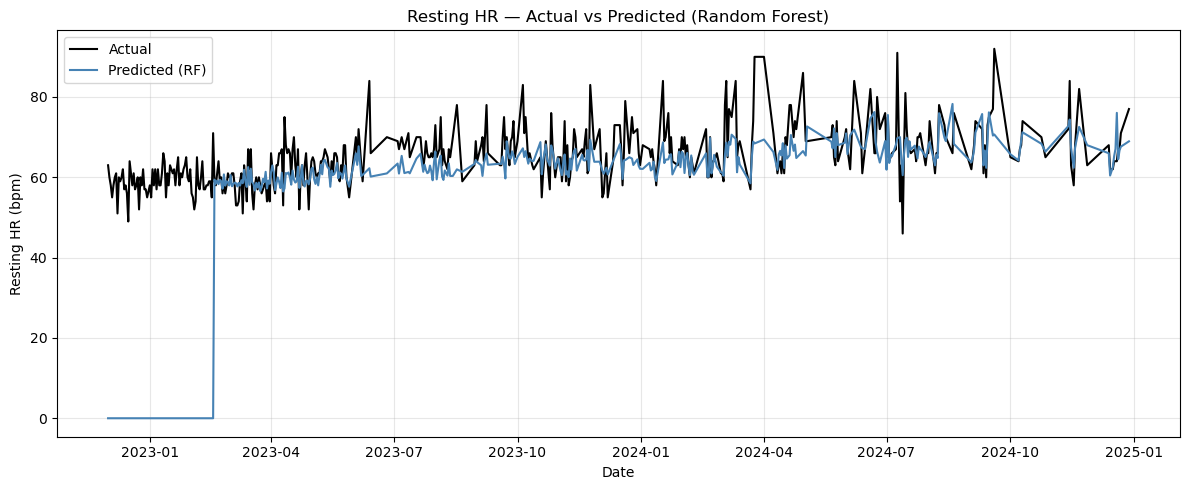

In [36]:
plt.figure(figsize=(12,5))
plt.plot(dates, y, label="Actual", color="black")
plt.plot(dates, pred_rf, label="Predicted (RF)", color="steelblue")
plt.title("Resting HR — Actual vs Predicted (Random Forest)")
plt.xlabel("Date"); plt.ylabel("Resting HR (bpm)")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


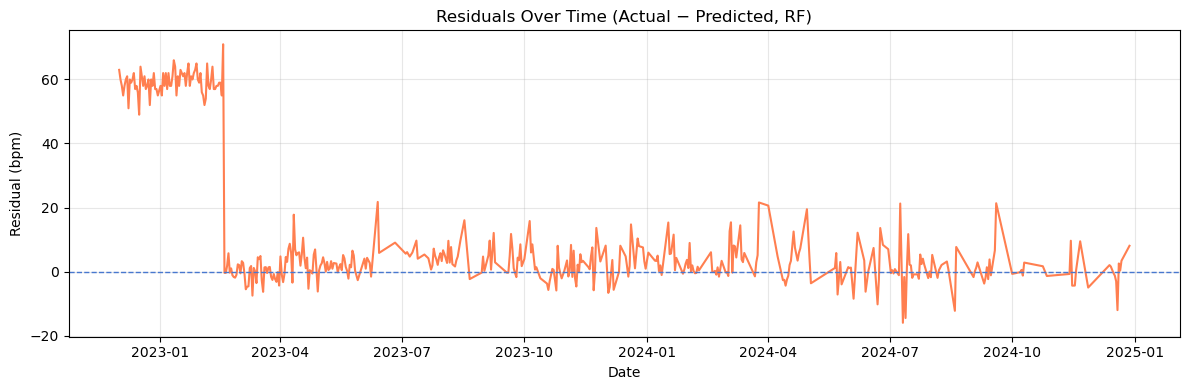

In [37]:
resid = y - pred_rf

plt.figure(figsize=(12,4))
plt.plot(dates, resid, color="coral")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Actual − Predicted, RF)")
plt.xlabel("Date"); plt.ylabel("Residual (bpm)")
plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [41]:
pred_df = pd.DataFrame({
    "date": dates,
    "Actual_RestingHR": y.values,
    "Pred_RestingHR_RF": pred_rf,
    "Residual_RF": y.values - pred_rf
})

pred_df

,date,Actual_RestingHR,Pred_RestingHR_RF,Residual_RF
0,2022-12-01,63.0,0.000,63.000
1,2022-12-02,60.0,0.000,60.000
2,2022-12-03,58.0,0.000,58.000
3,2022-12-04,55.0,0.000,55.000
4,2022-12-05,58.0,0.000,58.000
...,...,...,...,...
447,2024-12-19,64.0,76.050,-12.050
448,2024-12-20,67.0,64.485,2.515
449,2024-12-21,67.0,66.705,0.295
450,2024-12-22,71.0,67.630,3.370
